Prepare the data
Check the data and its stationarity

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima

C:\Users\ROG\AppData\Local\Temp\ipykernel_20956\4202726205.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_excel("C:/Users/ROG/Desktop/so this is the sadness/MINI Project/Data/candlestick_chart_data.xlsx", index_col='Date', parse_dates=['Date'])
pd.set_option('display.max_columns', None)
print(stock_data)

            Opening price  Highest price  Lowest price  Closing price  \
Date                                                                    
2025-01-02            267            303           243            288   
2025-01-03            281            317           270            291   
2025-01-06            278            346           276            327   
2025-01-07            336            388           317            369   
2025-01-08            365            374           303            311   
...                   ...            ...           ...            ...   
2025-06-25             96            114            93            104   
2025-06-26            113            114            94            111   
2025-06-27            106            113            93            111   
2025-06-30            103            113            93            110   
2025-07-01             94            114            93            107   

            Trading volume  Turnover  Median price

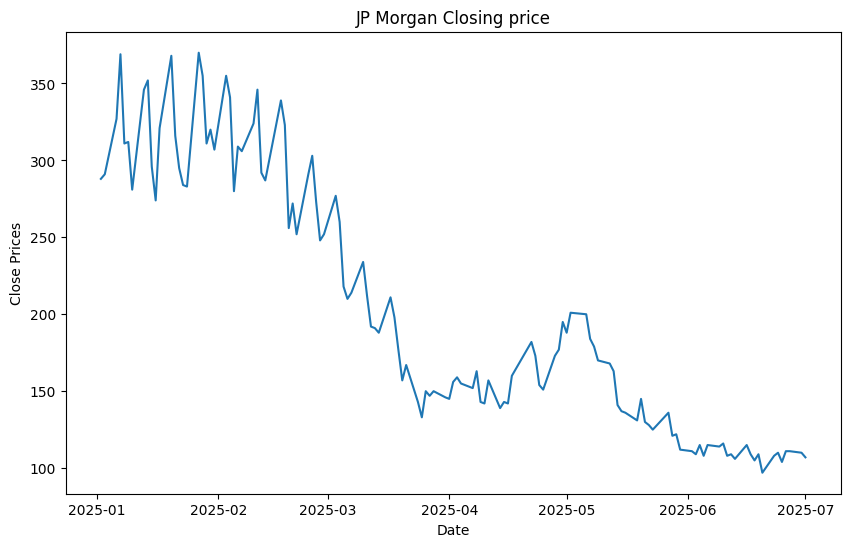

In [3]:
#Visualize the per day closing price of the stock.
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Closing price'])
plt.title('JP Morgan Closing price')
plt.show()


<Axes: ylabel='Density'>

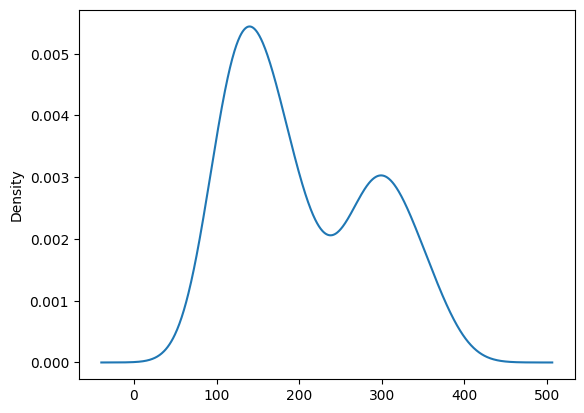

In [4]:
# Distribution of the dataset
df_close=stock_data['Closing price']
df_close.plot(kind='kde')

In [5]:
#Using the ADF test to check if a series is stationary or not because time series analysis only works with stationary data
def test_stationarity(timeseries):
    print("Results for dickey fuller test")
    results=adfuller(timeseries, autolag='AIC')
    output=pd.Series(results[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in results[4].items():
        output['critical value (%s)'%key] =values
    print(output)

In [6]:
test_stationarity(df_close)

Results for dickey fuller test
Test Statistics                 -0.922090
p-value                          0.780611
No. of lags used                10.000000
Number of observations used    114.000000
critical value (1%)             -3.489058
critical value (5%)             -2.887246
critical value (10%)            -2.580481
dtype: float64


Text(0.5, 1.0, '2 order differencing')

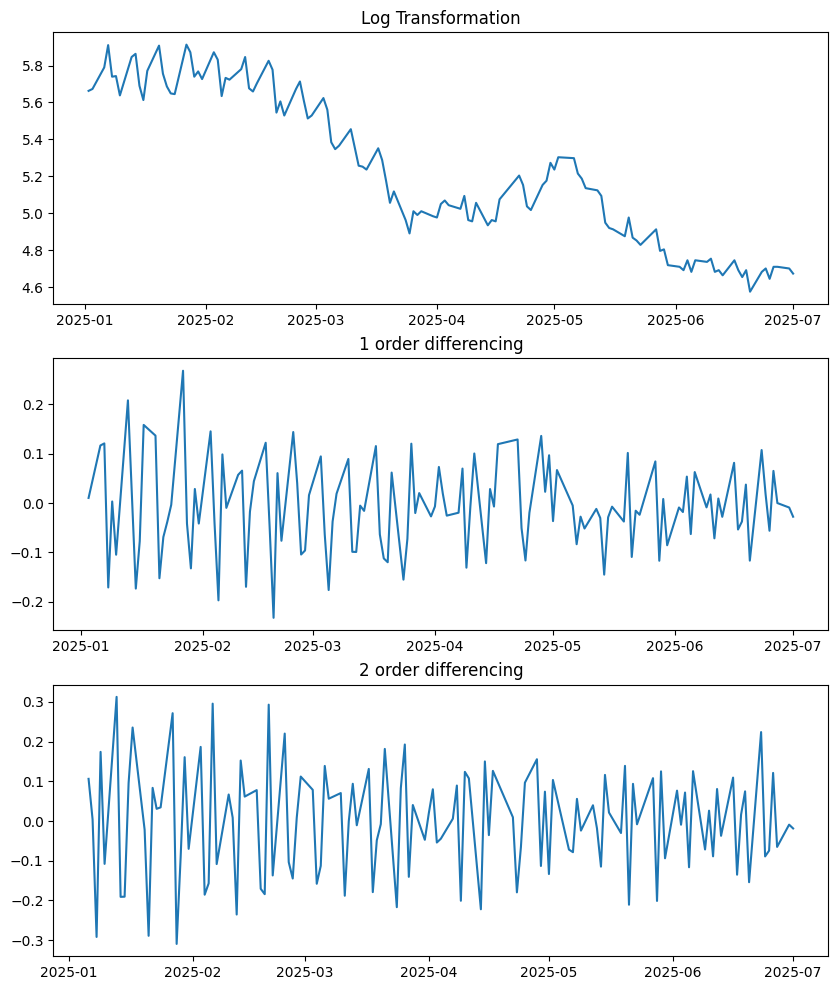

In [7]:
# # Nomalization
# avg, dev=df_close.mean(),df_close.std()
# df_nomal=(df_close-avg)/dev
# df_nomal.plot()
# # Log transformation
df_log=np.log(df_close)
fig,axe = plt.subplots(3,1, figsize=(10,12))
axe[0].plot(df_log)
axe[0].set_title('Log Transformation')
# Take first difference to remove the trend
df_diff=df_log.diff().dropna()
axe[1].plot(df_diff)
axe[1].set_title('1 order differencing')

df_diff_2=df_diff.diff().dropna()
axe[2].plot(df_diff_2)
axe[2].set_title('2 order differencing')

In [8]:
test_stationarity(df_diff)

Results for dickey fuller test
Test Statistics                 -3.701667
p-value                          0.004090
No. of lags used                 5.000000
Number of observations used    118.000000
critical value (1%)             -3.487022
critical value (5%)             -2.886363
critical value (10%)            -2.580009
dtype: float64


In [9]:
test_stationarity(df_diff_2)

Results for dickey fuller test
Test Statistics               -6.966868e+00
p-value                        8.868723e-10
No. of lags used               8.000000e+00
Number of observations used    1.140000e+02
critical value (1%)           -3.489058e+00
critical value (5%)           -2.887246e+00
critical value (10%)          -2.580481e+00
dtype: float64


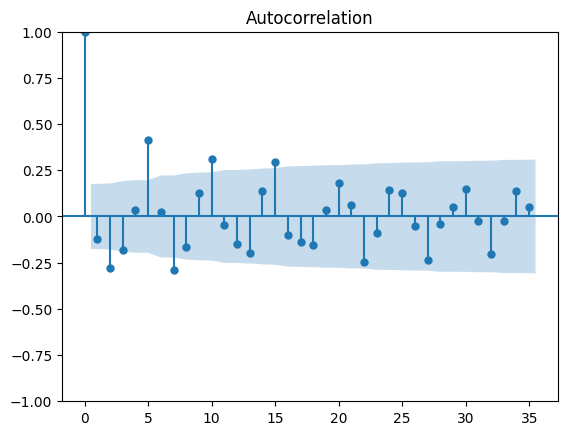

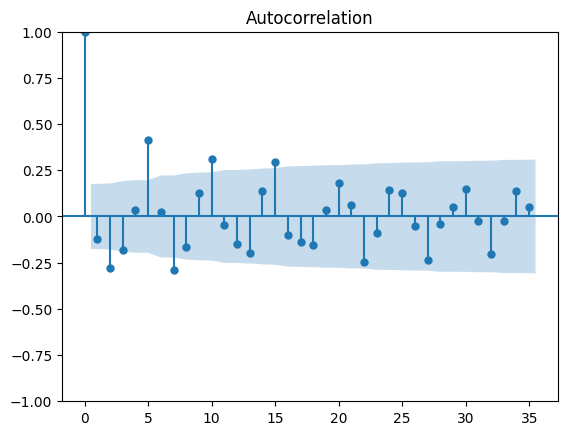

In [10]:
n_lags=35
plot_acf(df_diff,lags=n_lags, alpha=0.05)

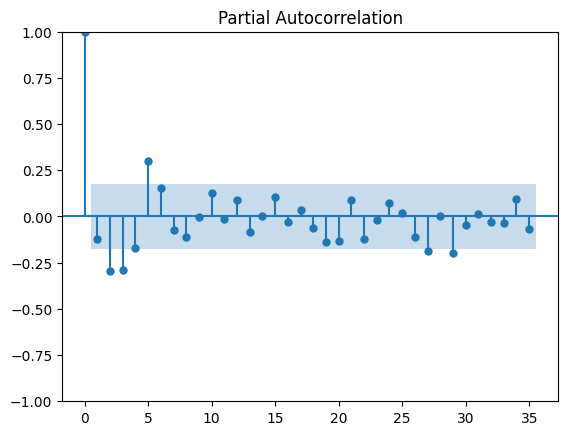

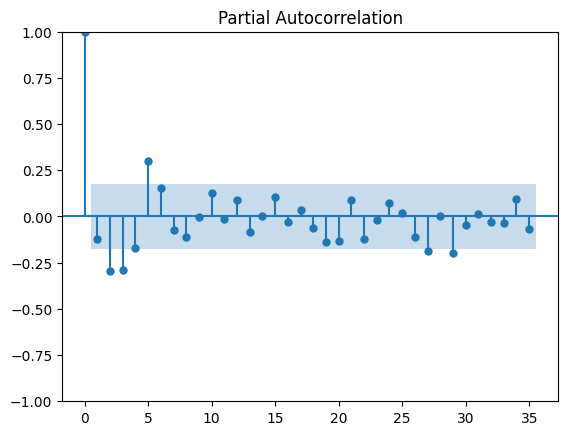

In [11]:
plot_pacf(df_diff,lags=n_lags)

Split data

In [12]:
def train_test_split(df,size=0.8):
    train_data, test_data=df[:int(len(df)*size)], df[int(len(df)*size):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df,'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()
    return train_data, test_data

DatetimeIndex(['2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-13',
               '2025-01-14', '2025-01-15',
               ...
               '2025-06-18', '2025-06-19', '2025-06-20', '2025-06-23',
               '2025-06-24', '2025-06-25', '2025-06-26', '2025-06-27',
               '2025-06-30', '2025-07-01'],
              dtype='datetime64[ns]', name='Date', length=125, freq=None)


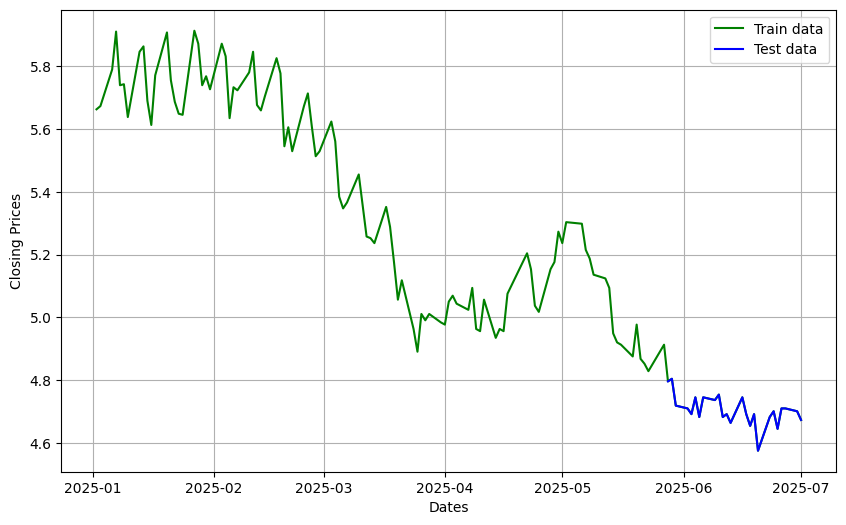

In [13]:
print(df_log.index)
train_data,test_data=train_test_split(df_log, 0.8)

In [14]:
train_data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-05-20    4.976734
2025-05-21    4.867534
2025-05-22    4.852030
2025-05-23    4.828314
2025-05-27    4.912655
Name: Closing price, Length: 100, dtype: float64

In [15]:
test_data

Date
2025-05-28    4.795791
2025-05-29    4.804021
2025-05-30    4.718499
2025-06-02    4.709530
2025-06-03    4.691348
2025-06-04    4.744932
2025-06-05    4.682131
2025-06-06    4.744932
2025-06-09    4.736198
2025-06-10    4.753590
2025-06-11    4.682131
2025-06-12    4.691348
2025-06-13    4.663439
2025-06-16    4.744932
2025-06-17    4.691348
2025-06-18    4.653960
2025-06-19    4.691348
2025-06-20    4.574711
2025-06-23    4.682131
2025-06-24    4.700480
2025-06-25    4.644391
2025-06-26    4.709530
2025-06-27    4.709530
2025-06-30    4.700480
2025-07-01    4.672829
Name: Closing price, dtype: float64

Model Selection

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA par

AIC for ARIMA(1,1,1):-183.77697749826984
AIC for ARIMA(1,1,2):-187.86826437126214
AIC for ARIMA(1,1,3):-189.96662752936876
AIC for ARIMA(1,1,4):-188.5973472945471
AIC for ARIMA(1,1,5):-196.2305215468837
AIC for ARIMA(2,1,1):-190.80137022597364
AIC for ARIMA(2,1,2):-205.34332105351285
AIC for ARIMA(2,1,3):-208.5197558910358
AIC for ARIMA(2,1,4):-206.81306530359845
AIC for ARIMA(2,1,5):-208.5845987837858
AIC for ARIMA(3,1,1):-191.95973213557295
AIC for ARIMA(3,1,2):-208.09484639630205
AIC for ARIMA(3,1,3):-202.14952544270452
AIC for ARIMA(3,1,4):-207.93760752116867
AIC for ARIMA(3,1,5):-207.6425852564994
AIC for ARIMA(4,1,1):-198.53207496057252
AIC for ARIMA(4,1,2):-203.8605589400754
AIC for ARIMA(4,1,3):-210.03512738182133
AIC for ARIMA(4,1,4):-208.5439777799538
AIC for ARIMA(4,1,5):-206.50349501911154
AIC for ARIMA(5,1,1):-207.65315602153163
AIC for ARIMA(5,1,2):-208.00266288466264
AIC for ARIMA(5,1,3):-208.3910803260443
AIC for ARIMA(5,1,4):-207.03683933990004
AIC for ARIMA(5,1,5):-20

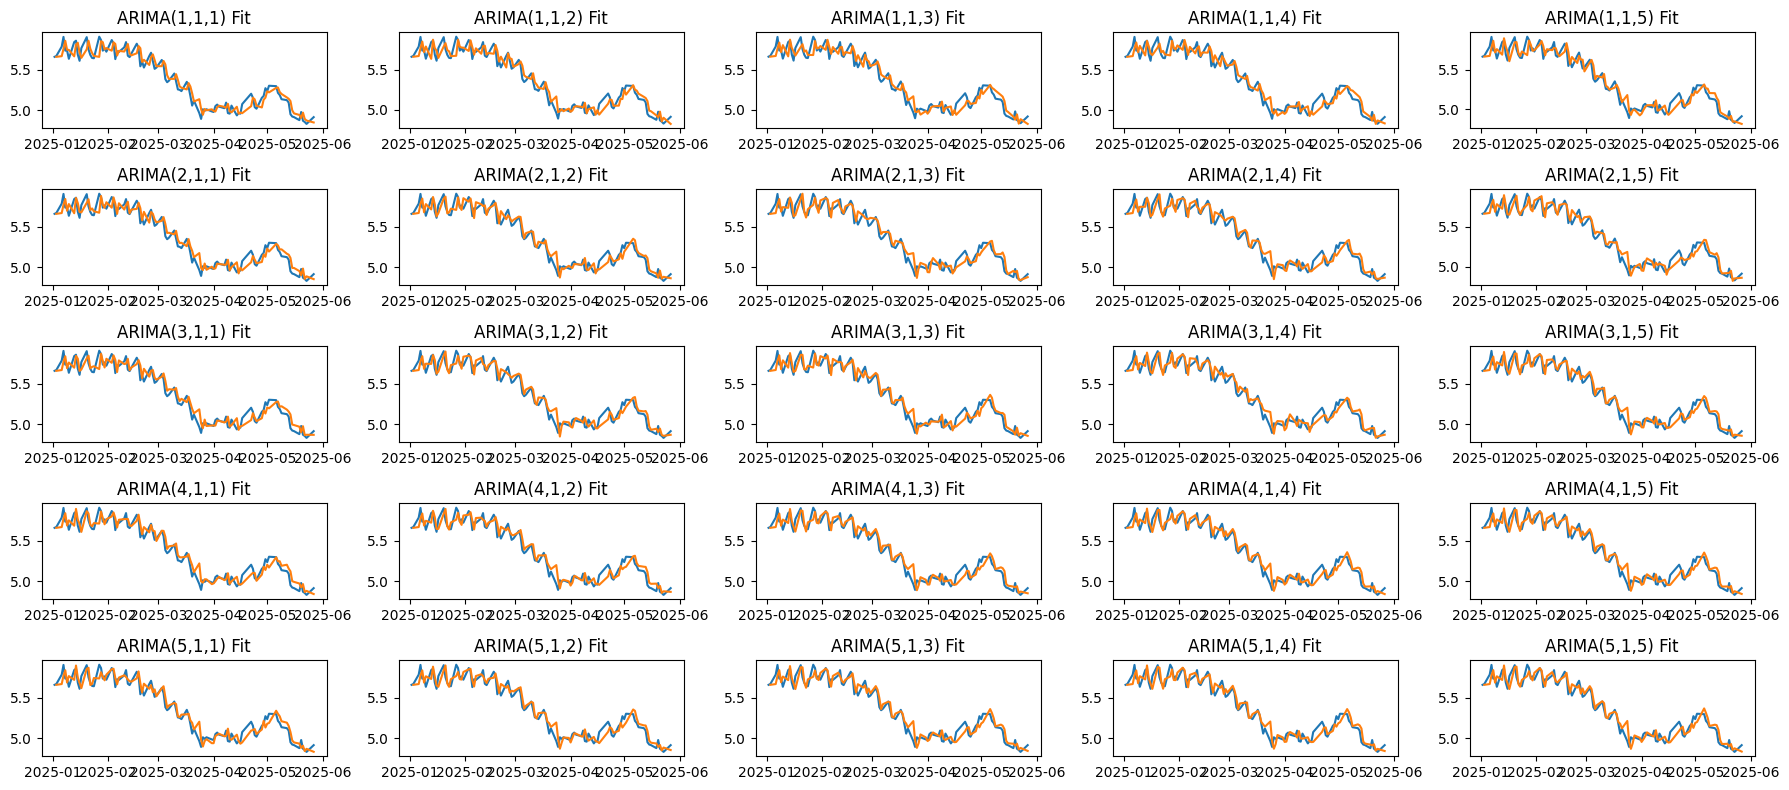

In [16]:
# model selection
ar_orders=[1,2,3,4,5]
ma_orders=[1,2,3,4,5]
fitted_model_dict={}
AIC_dict={}
fig,axes=plt.subplots(len(ar_orders),len(ma_orders),figsize=(18,8))
for idx, ar_order in enumerate(ar_orders):
    for idy, ma_order in enumerate(ma_orders):
        # create ARIMA model
        model=ARIMA(train_data, order=(ar_order,1,ma_order))
        model_fit = model.fit()
        fitted_model_dict[ar_order,ma_order]=model_fit
        AIC_dict[ar_order,ma_order]=fitted_model_dict[ar_order,ma_order].aic
        ax = axes[idx, idy]
        ax.set_title('ARIMA(%s,1,%s) Fit'%(ar_order,ma_order))
        ax.plot(train_data)
        ax.plot(model_fit.fittedvalues[1:])
plt.tight_layout()
for ar_order in ar_orders:
    for ma_order in ma_orders:
        print('AIC for ARIMA(%s,1,%s):%s'%(ar_order,ma_order,AIC_dict[ar_order,ma_order]))

In [17]:
# Sort the dictionary by value and return the first key-value pair
min_key, min_val = sorted(AIC_dict.items(), key=lambda x: x[1])[0]
print("The ARIMA model with the lowest AIC is: (%s,1,%s)"%(min_key[0],min_key[1]))

The ARIMA model with the lowest AIC is: (4,1,3)


Type Markdown and $$Latex:\alpha^{2}$$

Figure(1500x800)


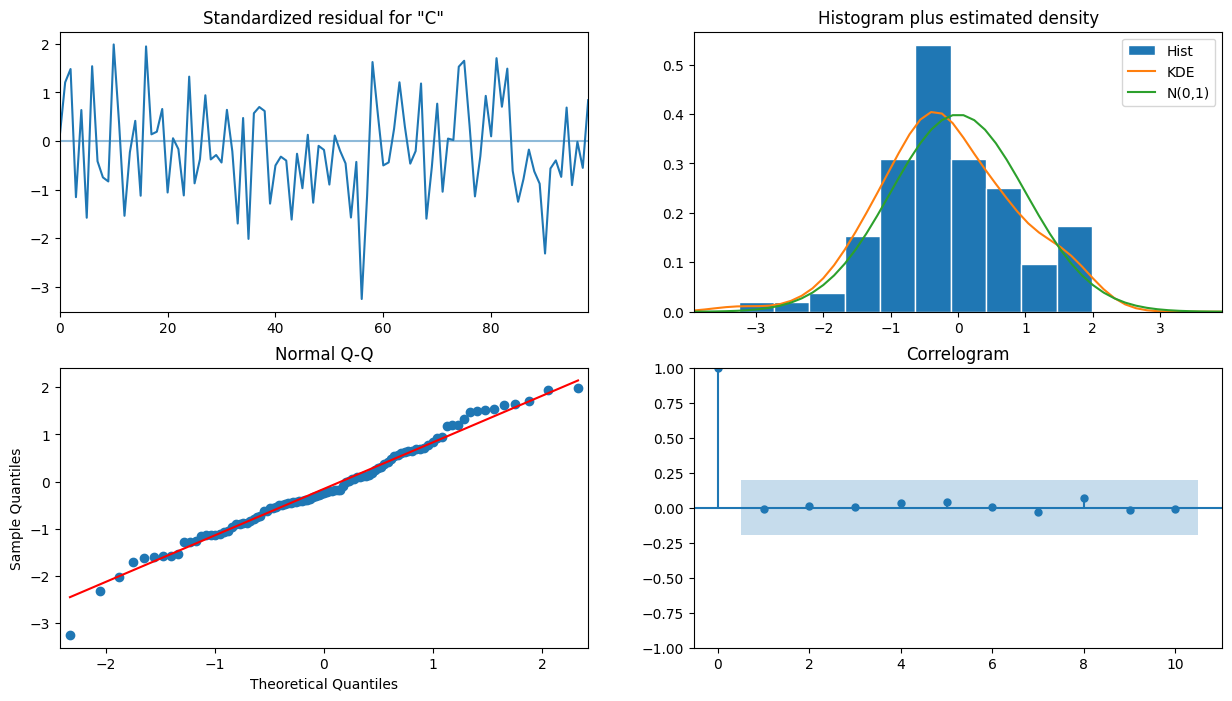

In [18]:
print(fitted_model_dict[min_key[0],min_key[1]].plot_diagnostics(figsize=(15,8)))

Test the data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-05-20    4.976734
2025-05-21    4.867534
2025-05-22    4.852030
2025-05-23    4.828314
2025-05-27    4.912655
Name: Closing price, Length: 100, dtype: float64
Date
2025-01-02    0.000000
2025-01-03    5.662960
2025-01-06    5.672593
2025-01-07    5.775403
2025-01-08    5.840682
                ...   
2025-05-20    4.924247
2025-05-21    4.936967
2025-05-22    4.853330
2025-05-23    4.870609
2025-05-27    4.848502
Length: 100, dtype: float64


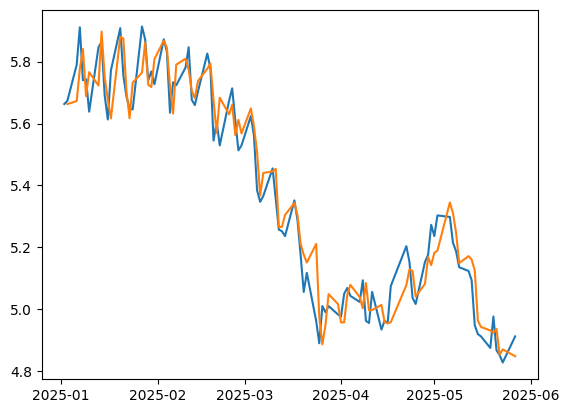

In [19]:
model_fit=fitted_model_dict[min_key[0],min_key[1]]
#model_fit=fitted_model_dict[3,2]
#get the predictions and residuals
predictions=model_fit.fittedvalues
# residuals = test_data - predictions
print(train_data)
print(predictions)
plt.plot(train_data)
plt.plot(predictions[1:])

In [20]:
pre_test=model_fit.forecast(steps=len(test_data))
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
print(pre_test)

100    4.943897
101    4.887173
102    4.876578
103    4.860780
104    4.917977
105    4.926263
106    4.899367
107    4.863630
108    4.874302
109    4.914589
110    4.925844
111    4.894725
112    4.864520
113    4.878790
114    4.915634
115    4.923047
116    4.891212
117    4.865918
118    4.882583
119    4.916657
120    4.919836
121    4.888412
122    4.867468
123    4.886167
124    4.917209
Name: predicted_mean, dtype: float64


C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
fc_series = pd.Series(np.array(pre_test), index=test_data.index)
fc_series

Date
2025-05-28    4.943897
2025-05-29    4.887173
2025-05-30    4.876578
2025-06-02    4.860780
2025-06-03    4.917977
2025-06-04    4.926263
2025-06-05    4.899367
2025-06-06    4.863630
2025-06-09    4.874302
2025-06-10    4.914589
2025-06-11    4.925844
2025-06-12    4.894725
2025-06-13    4.864520
2025-06-16    4.878790
2025-06-17    4.915634
2025-06-18    4.923047
2025-06-19    4.891212
2025-06-20    4.865918
2025-06-23    4.882583
2025-06-24    4.916657
2025-06-25    4.919836
2025-06-26    4.888412
2025-06-27    4.867468
2025-06-30    4.886167
2025-07-01    4.917209
dtype: float64

<Axes: xlabel='Date'>

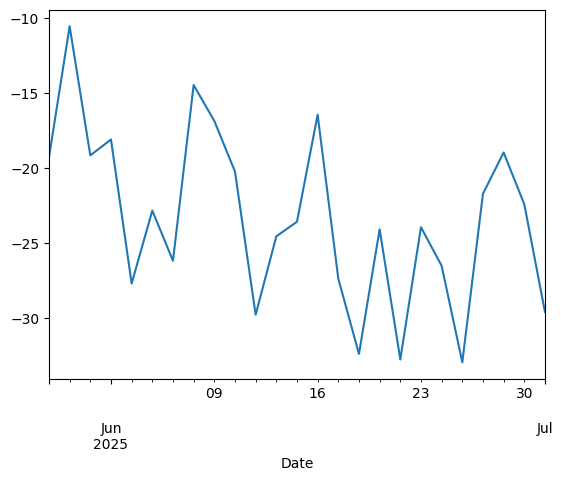

In [22]:
residuals=np.exp(test_data)-np.exp(fc_series)
residuals.plot()

RMSE: 24.022553280143583
MAPE: 0.21362772137357489


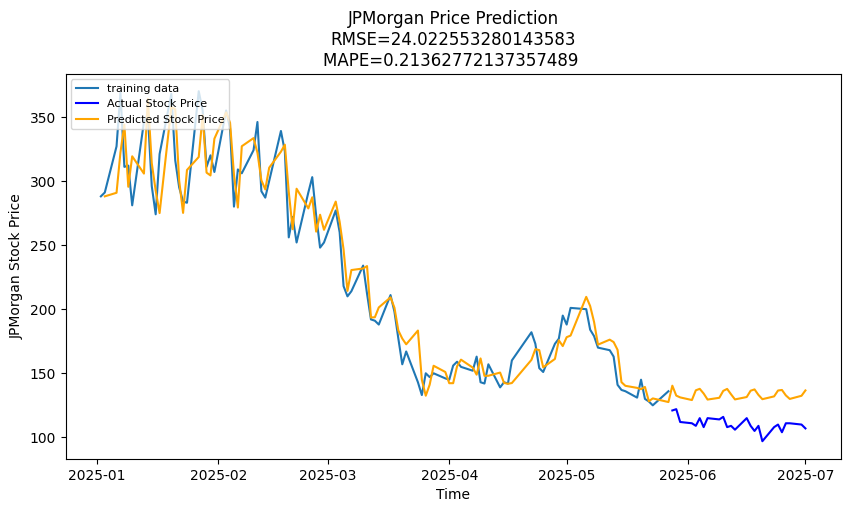

In [23]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
concat_df=[predictions[1:],fc_series]
pred_df=pd.concat(concat_df)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(pred_df), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('JPMorgan Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Using Auto-ARIMA Model

Rolling Forecasting Origin

In [24]:
# create the model 
from datetime import timedelta
predictions_rolling=pd.Series(dtype=float)
for end_date in test_data.index:
    train_data=df_log[:end_date-timedelta(days=1)]
    model=auto_arima(train_data, seasonal=False,stepwise=True,suppress_warnings=True,error_action='ignore',max_order=None,trace=False)
    pred = model.predict(n_periods=1)
    predictions_rolling.loc[end_date]=pred.values[0]
print(model.summary())

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next vers

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 145.587
Date:                Tue, 12 Mar 2024   AIC                           -277.173
Time:                        02:08:16   BIC                           -257.488
Sample:                             0   HQIC                          -269.177
                                - 124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0122      0.006     -2.116      0.034      -0.024      -0.001
ar.L1          0.5641      0.024     23.933      0.000       0.518       0.610
ar.L2         -0.9825      0.015    -64.014      0.0

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


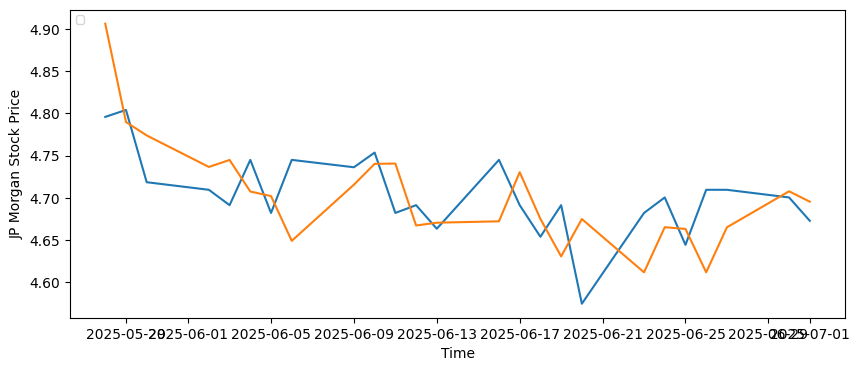

In [25]:
# draw the prediction plot
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling)

plt.xlabel('Time')
plt.ylabel('JP Morgan Stock Price')
plt.legend(loc='upper left', fontsize=8)

In [26]:
residuals_rolling=np.exp(test_data)-np.exp(predictions_rolling) # get the residuals
print(residuals_rolling)
print(predictions_rolling)

Date
2025-05-28   -14.105815
2025-05-29     1.728822
2025-05-30    -6.377108
2025-06-02    -3.042883
2025-06-03    -5.985861
2025-06-04     4.224748
2025-06-05    -2.175268
2025-06-06    10.507761
2025-06-09     2.324521
2025-06-10     1.537174
2025-06-11    -6.500729
2025-06-12     2.593887
2025-06-13    -0.762148
2025-06-16     8.063808
2025-06-17    -4.331274
2025-06-18    -2.240515
2025-06-19     6.413298
2025-06-20   -10.225960
2025-06-23     7.329173
2025-06-24     3.806163
2025-06-25    -1.973501
2025-06-26    10.326316
2025-06-27     4.820744
2025-06-30    -0.803425
2025-07-01    -2.447973
dtype: float64
2025-05-28    4.906058
2025-05-29    4.789749
2025-05-30    4.773875
2025-06-02    4.736575
2025-06-03    4.744809
2025-06-04    4.707503
2025-06-05    4.702072
2025-06-06    4.649113
2025-06-09    4.715597
2025-06-10    4.740250
2025-06-11    4.740581
2025-06-12    4.667263
2025-06-13    4.670603
2025-06-16    4.672232
2025-06-17    4.730315
2025-06-18    4.675074
2025-06-19  

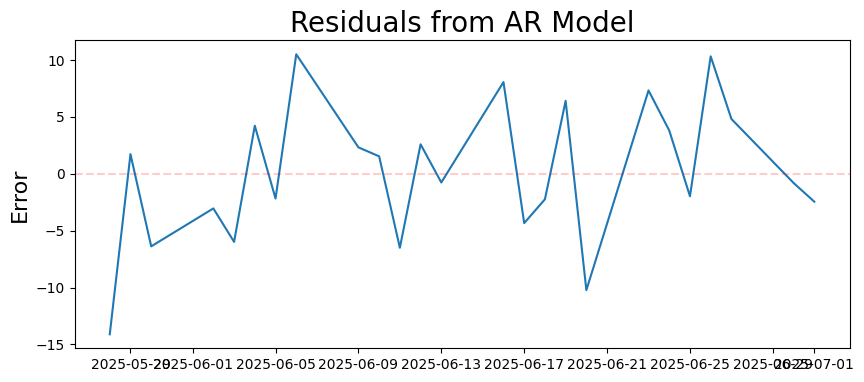

In [27]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)

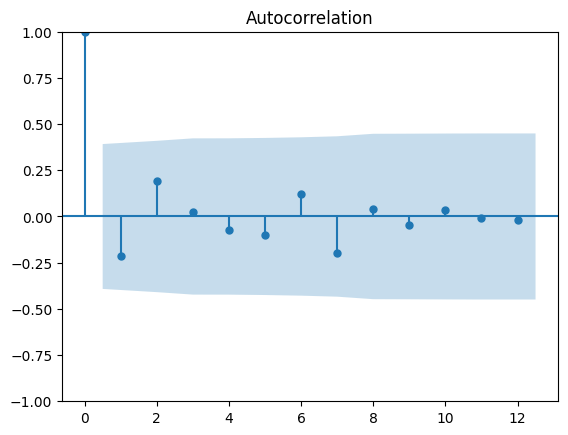

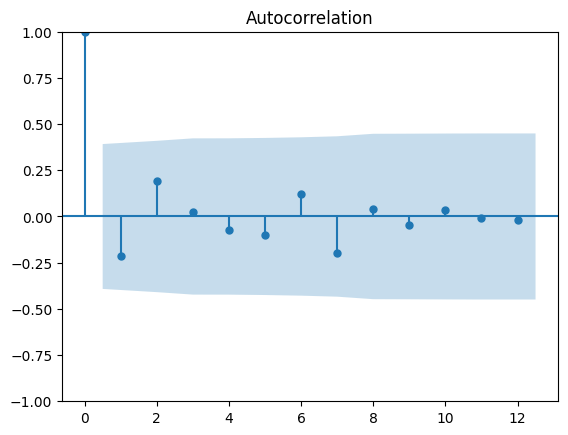

In [28]:
plot_acf(residuals_rolling,lags=12)

In [29]:
print('Mean Absolute Percent Error:',round(np.mean(abs(residuals_rolling/np.exp(test_data))),4))
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.0451
Root Mean Squared Error: 6.070131856838968


RMSE: 6.070131856838968
MAPE: 0.04506495471755631


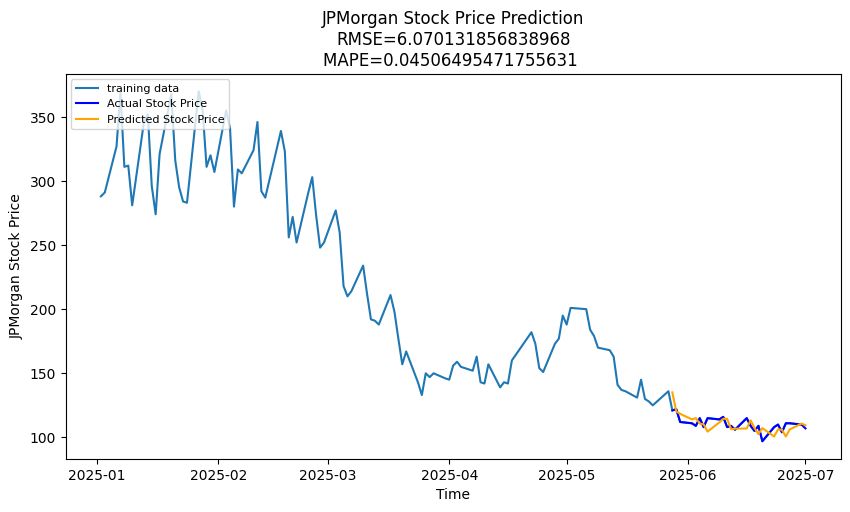

In [30]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(predictions_rolling), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(predictions_rolling)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals_rolling)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('JPMorgan Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()